In [1]:
# pip install -U giotto-tda

In [2]:
# pip install julia

# Imports

In [3]:
import numpy as np

from gtda.homology import VietorisRipsPersistence
from gtda.time_series import SingleTakensEmbedding
from gtda.diagrams import BettiCurve, PersistenceLandscape, PairwiseDistance, PersistenceEntropy
from gtda.plotting import plot_point_cloud, plot_diagram
from gtda.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

from pathlib import Path
from sklearn.datasets import make_circles
import plotly.graph_objects as go

import nolds
from GP_algorythm import grassberg_procaccia
from statsmodels.graphics.tsaplots import plot_acf

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf

from scipy.fft import fft, fftfreq

import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# from julia.api import Julia
# jl = Julia(compiled_modules=False)
# from julia import Main
# jl.using("Eirene")

In [4]:
PATH = Path("../data")

In [5]:
def get_data_from_pq_to_pd(data_path: str, n_series: int = None):
    data = pq.read_table(data_path)
    data = data.to_pandas(categories=['string', 'int', 'datetime', 'float', 'float'])
    if n_series is not None:
        series_ids = data.series_id.unique()
        data = data[data.series_id.isin(series_ids[:n_series])]
    data.timestamp = pd.to_datetime(data.timestamp, format="%Y-%m-%dT%H:%M:%S%z")
    print('Types of columns:')
    print(data.dtypes, end='\n\n')
    print('Shape:', data.shape)
    return data

`anglez` - As calculated and described by the GGIR package, z-angle is a metric derived from individual accelerometer components that is commonly used in sleep detection, and refers to the angle of the arm relative to the vertical axis of the body


`enmo` - As calculated and described by the GGIR package, ENMO is the Euclidean Norm Minus One of all accelerometer signals, with negative values rounded to zero. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features

In [6]:
# train_series = get_data_from_pq_to_pd(r'/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet', 1)
train_series = pd.read_csv(PATH / 'train_series.csv')
train_series.head()

,Unnamed: 0,series_id,step,timestamp,anglez,enmo
0,0,038441c925bb,0,2018-08-14 15:30:00-04:00,2.6367,0.0217
1,1,038441c925bb,1,2018-08-14 15:30:05-04:00,2.6368,0.0215
2,2,038441c925bb,2,2018-08-14 15:30:10-04:00,2.6370,0.0216
3,3,038441c925bb,3,2018-08-14 15:30:15-04:00,2.6368,0.0213
4,4,038441c925bb,4,2018-08-14 15:30:20-04:00,2.6368,0.0215


In [7]:
train_series.drop(["series_id", "Unnamed: 0", "step"], axis=1, inplace=True)

In [8]:
train_series["timestamp"] = pd.to_datetime(train_series["timestamp"])

In [9]:
train_series.head()

,timestamp,anglez,enmo
0,2018-08-14 15:30:00-04:00,2.6367,0.0217
1,2018-08-14 15:30:05-04:00,2.6368,0.0215
2,2018-08-14 15:30:10-04:00,2.6370,0.0216
3,2018-08-14 15:30:15-04:00,2.6368,0.0213
4,2018-08-14 15:30:20-04:00,2.6368,0.0215


In [10]:
train_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389880 entries, 0 to 389879
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype                    
---  ------     --------------   -----                    
 0   timestamp  389880 non-null  datetime64[ns, UTC-04:00]
 1   anglez     389880 non-null  float64                  
 2   enmo       389880 non-null  float64                  
dtypes: datetime64[ns, UTC-04:00](1), float64(2)
memory usage: 8.9 MB


In [11]:
# train_series.to_csv('train_series.csv')

In [19]:
anglez_series = train_series["anglez"].to_numpy()[800:2800] # train_series[train_series.series_id == '038441c925bb'].anglez
enmo_series = train_series["enmo"].to_numpy()[:2000]

# Временные ряды

In [20]:
fig = go.Figure(data=go.Scatter(y=anglez_series))
fig.update_layout(xaxis_title="Timestamp", yaxis_title="Anglez")
fig.show()

## Определение параметров 

### Размерность вложения

#### Метод корреляционной размерности (Метод Грассберга-Прокаччи)

 44%|████▍     | 26/59 [00:08<00:12,  2.54it/s]/home/vadim/projects/TDA_Uni/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

100%|██████████| 59/59 [00:23<00:00,  2.49it/s]


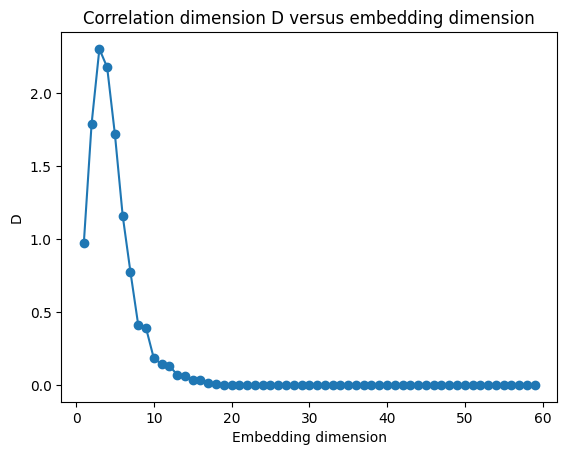

In [27]:
# Calculates the correlation dimension with the Grassberger-Procaccia algorithm
corr_dims = []
embd_dims_range = (1, 60)

for emb_dim in tqdm(range(*embd_dims_range)):
    D = nolds.corr_dim(train_series["anglez"].to_numpy()[800:2800], emb_dim)
    corr_dims.append(D)

plt.plot(range(*embd_dims_range), corr_dims, 'o-')
plt.xlabel("Embedding dimension")
plt.ylabel("D")
plt.title("Correlation dimension D versus embedding dimension")
plt.show()


### Определение временной задержки
#### FFT 

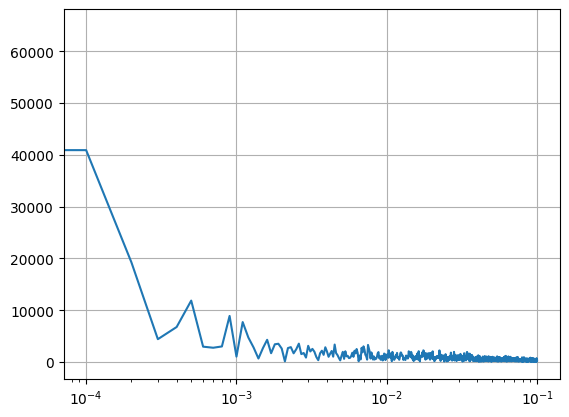

In [88]:
# Number of sample points
N = anglez_series.shape[0]
SAMPLE_RATE = 1 / (train_series["timestamp"][1] - train_series["timestamp"][0]).total_seconds()


yf = fft(anglez_series)[:N//2]
xf = fftfreq(N, d=1/SAMPLE_RATE)[:N//2]

plt.plot(xf, np.abs(yf))
plt.xscale('log')
plt.grid()
plt.show()

64870.1124

In [79]:
embedding_dimension_periodic = 17
embedding_time_delay_periodic = 20

embedder = SingleTakensEmbedding(
    parameters_type="fixed",
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=500 # Иначе слишком много значений, и вычисления не произвести
)

anglez_point_cloud = embedder.fit_transform(anglez_series)
enmo_point_cloud = embedder.fit_transform(enmo_series)

In [80]:
anglez_point_cloud.shape

(780, 17)

In [81]:
plot_point_cloud(anglez_point_cloud).show()

In [82]:
# 0 - connected components, 1 - loops, 2 - voids
homology_dimensions = [0, 1, 2]

persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions
)

In [83]:
diagrams = persistence.fit_transform([anglez_point_cloud, enmo_point_cloud])

In [84]:
VR = VietorisRipsPersistence()
VR.plot(diagrams, sample=0)

In [85]:
VR.plot(diagrams, sample=1)

In [86]:
p_W = 2
PD = PairwiseDistance(metric='wasserstein',
                      metric_params={'p': p_W, 'delta': 0.1},
                      order=None)

PD.fit_transform(diagrams)

array([[[   0.        ,    0.        ,    0.        ],
        [1091.25707317,   46.96343446,    4.95814048]],

       [[1091.12925781,   46.96343446,    4.95814048],
        [   0.        ,    0.        ,    0.        ]]])

In [ ]:
PD = PairwiseDistance(metric='bottleneck',
                      metric_params={'delta': 0.1},
                      order=None)

PD.fit_transform(diagrams)

array([[[ 0.        ,  0.        ,  0.        ],
        [27.94665686,  6.22183067,  1.03077694]],

       [[28.82816498,  6.30248683,  1.03302296],
        [ 0.        ,  0.        ,  0.        ]]])

In [ ]:
BC = BettiCurve()
betti_curves = BC.fit_transform(diagrams)

In [ ]:
BC.plot(betti_curves, sample=0)

In [ ]:
BC.plot(betti_curves, sample=1)

In [ ]:
PD = PairwiseDistance(metric='betti',
                      metric_params={'p': 1},
                      order=None)

PD.fit_transform(diagrams)

array([[[   0.        ,    0.        ,    0.        ],
        [4596.07099302,  375.8576501 ,   15.13717679]],

       [[4596.07099302,  375.8576501 ,   15.13717679],
        [   0.        ,    0.        ,    0.        ]]])

In [ ]:
PL = PersistenceLandscape()
persistence_landscapes = PL.fit_transform(diagrams)

In [ ]:
PL.plot(persistence_landscapes, sample=0)

In [ ]:
PL.plot(persistence_landscapes, sample=1)

In [ ]:
PD = PairwiseDistance(metric='landscape',
                      metric_params={'p': 1},
                      order=None)

PD.fit_transform(diagrams)

array([[[  0.        ,   0.        ,   0.        ],
        [735.47686142, 101.94477384,   2.70576992]],

       [[735.47686142, 101.94477384,   2.70576992],
        [  0.        ,   0.        ,   0.        ]]])

# Машинное обучение

In [ ]:
# Track connected components, loops, and voids
homology_dimensions = [0, 1, 2]

# Collapse edges to speed up H2 persistence calculation!
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    collapse_edges=True,
)

diagrams_basic = persistence.fit_transform(point_clouds_basic)

In [ ]:
# Circle
plot_diagram(diagrams_basic[0])

In [ ]:
#spheres
plot_diagram(diagrams_basic[10])

In [ ]:
#tori
plot_diagram(diagrams_basic[-1])

In [ ]:
persistence_entropy = PersistenceEntropy()

# calculate topological feature matrix
X_basic = persistence_entropy.fit_transform(diagrams_basic)

In [ ]:
plot_point_cloud(X_basic)

In [ ]:
rf = RandomForestClassifier(oob_score=True)
rf.fit(X_basic, labels_basic)

print(f"OOB score: {rf.oob_score_:.3f}")

In [ ]:
steps = [
    ("persistence", VietorisRipsPersistence(metric="euclidean", homology_dimensions=homology_dimensions, n_jobs=6)),
    ("entropy", PersistenceEntropy()),
    ("model", RandomForestClassifier(oob_score=True)),
]

pipeline = Pipeline(steps)

pipeline.fit(point_clouds_basic, labels_basic)

Pipeline(steps=[('persistence',
                 VietorisRipsPersistence(homology_dimensions=[0, 1, 2])),
                ('entropy', PersistenceEntropy()),
                ('model', RandomForestClassifier(oob_score=True))])

pipeline["model"].oob_score_

Julia + Eirene

In [ ]:
x = Main.rand(3,50)
plot_point_cloud(x.T)

In [ ]:
C = Main.eirene(x, model = "pc")

In [ ]:
A0 = Main.barcode(C, dim=0)
A0 = np.append(np.array(A0), np.zeros((len(A0), 1)), axis= 1 )
A0 = np.delete(A0, -1, 0)

In [ ]:
A1 = Main.barcode(C, dim=1)
A1 = np.append(np.array(A1), np.ones((len(A1), 1)), axis= 1 )

In [ ]:
A = np.concatenate((A0, A1), axis=0)
plot_diagram(A)

In [ ]:
Main.wasserstein_distance(dgm1, dgm2, q=q, p=p)

In [ ]:
Main.betticurve(C, dim=0)

In [ ]:
Main.betticurve(C, dim=1)

In [ ]:
BC = BettiCurve()
betti_curves = BC.fit_transform([A])
BC.plot(betti_curves, sample=0)

In [ ]:
Main.classrep(C, dim=1)

In [ ]:
Main.classrep(C, dim=0)

In [ ]:
Main.classrep(C, dim=0, class=1)